In [0]:
#Import the dependencies
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

In [0]:
# Import the dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
tf.reset_default_graph()
batch_size = 200
n_noise = 100

In [0]:
#Define the Placeholders
samples = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
noise = tf.placeholder(dtype=tf.float32, shape=[None, n_noise])

keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')
is_train = tf.placeholder(dtype=tf.bool, name='is_train')

def lrelu(x):
    return tf.maximum(x, tf.multiply(x, 0.2))

def binary_cross_entropy(x, z):
    eps = 1e-12
    return (-(x * tf.log(z + eps) + (1. - x) * tf.log(1. - z + eps)))

In [0]:
def discriminator(samples, reuse=None, keep_prob=keep_prob):
    activation = lrelu
    with tf.variable_scope("discriminator", reuse=reuse):
        reshape = tf.reshape(samples, shape=[-1, 28, 28, 1])
        conv_1 = tf.layers.conv2d(reshape, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        a_1 = tf.layers.dropout(conv_1, keep_prob)
        conv_2 = tf.layers.conv2d(a_1, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        a_2 = tf.layers.dropout(conv_2, keep_prob)
        conv_3 = tf.layers.conv2d(a_2, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        a_3 = tf.layers.dropout(conv_3, keep_prob)
        flatten = tf.contrib.layers.flatten(a_3)
        fc_1 = tf.layers.dense(flatten, units=128, activation=activation)
        y = tf.layers.dense(fc_1, units=1, activation=tf.nn.sigmoid)
        return y

In [0]:
def generator(z, keep_prob=keep_prob, is_train=is_train):
    activation = lrelu
    momentum = 0.99
    with tf.variable_scope("generator", reuse=None):

        fc_1 = tf.layers.dense(z, units=7 * 7 * 1, activation=activation)
        z_1 = tf.layers.dropout(fc_1, keep_prob)      
        a_1 = tf.contrib.layers.batch_norm(z_1, is_training=is_train, decay=momentum)  
        reshape = tf.reshape(a_1, shape=[-1,7,7,1])
        convt_1 = tf.layers.conv2d_transpose(reshape, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        z_2 = tf.layers.dropout(convt_1, keep_prob)
        a_2 = tf.contrib.layers.batch_norm(z_2, is_training=is_train, decay=momentum)
        convt_2 = tf.layers.conv2d_transpose(a_2, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        z_3 = tf.layers.dropout(convt_2, keep_prob)
        a_3 = tf.contrib.layers.batch_norm(z_3, is_training=is_train, decay=momentum)
        convt_3 = tf.layers.conv2d_transpose(a_3, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        z_3 = tf.layers.dropout(convt_3, keep_prob)
        a_3 = tf.contrib.layers.batch_norm(z_3, is_training=is_train, decay=momentum)
        img = tf.layers.conv2d_transpose(a_3, kernel_size=5, filters=1, strides=1, padding='same', activation=tf.nn.sigmoid)
        return img

In [0]:
g = generator(noise, keep_prob, is_train)
d_real = discriminator(samples)
d_fake = discriminator(g, reuse=True)

vars_g = [var for var in tf.trainable_variables() if var.name.startswith("generator")]
vars_d = [var for var in tf.trainable_variables() if var.name.startswith("discriminator")]

loss_d_real = binary_cross_entropy(tf.ones_like(d_real), d_real)
loss_d_fake = binary_cross_entropy(tf.zeros_like(d_fake), d_fake)
loss_g = tf.reduce_mean(binary_cross_entropy(tf.ones_like(d_fake), d_fake))
loss_d = tf.reduce_mean(0.5 * (loss_d_real + loss_d_fake))

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer_d = tf.train.AdamOptimizer(learning_rate=0.00015).minimize(loss_d, var_list=vars_d)
    optimizer_g = tf.train.AdamOptimizer(learning_rate=0.00015).minimize(loss_g, var_list=vars_g)
    
    
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
for e in range(64):
  start = time.time()
  for i in range(300):
    
    train_d = True
    train_g = True
    keep_prob_train = 0.6 # 0.5


    n = np.random.uniform(0.0, 1.0, [batch_size, n_noise]).astype(np.float32)   
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]  

    d_real_ls, d_fake_ls, g_ls, d_ls = sess.run([loss_d_real, loss_d_fake, loss_g, loss_d], feed_dict={samples: batch, noise: n, keep_prob: keep_prob_train, is_train:True})

    d_real_ls = np.mean(d_real_ls)
    d_fake_ls = np.mean(d_fake_ls)
    g_ls = g_ls
    d_ls = d_ls



    if g_ls * 1.5 < d_ls:
        train_g = False
        pass
    if d_ls * 2 < g_ls:
        train_d = False
        pass

    if train_d:
        sess.run(optimizer_d, feed_dict={noise: n, samples: batch, keep_prob: keep_prob_train, is_train:True})


    if train_g:
        sess.run(optimizer_g, feed_dict={noise: n, keep_prob: keep_prob_train, is_train:True})
        
  print('Epoch %i: g_ls: %f, d_ls: %f, time: %f sec' %(e + 1, g_ls, d_ls, time.time()-start))
    

Epoch 1: g_ls: 1.201799, d_ls: 0.504896, time: 25.501716 sec
Epoch 2: g_ls: 1.030253, d_ls: 0.498521, time: 27.016354 sec
Epoch 3: g_ls: 1.408460, d_ls: 0.557006, time: 24.883064 sec
Epoch 4: g_ls: 1.353331, d_ls: 0.565302, time: 25.281621 sec
Epoch 5: g_ls: 1.226494, d_ls: 0.502723, time: 25.701084 sec
Epoch 6: g_ls: 1.226020, d_ls: 0.579215, time: 24.548136 sec
Epoch 7: g_ls: 1.251517, d_ls: 0.593398, time: 25.483096 sec
Epoch 8: g_ls: 0.993377, d_ls: 0.581727, time: 26.553833 sec
Epoch 9: g_ls: 1.174749, d_ls: 0.527826, time: 26.280526 sec
Epoch 10: g_ls: 1.037638, d_ls: 0.538234, time: 26.128504 sec
Epoch 11: g_ls: 1.071553, d_ls: 0.515133, time: 26.194490 sec
Epoch 12: g_ls: 1.150298, d_ls: 0.501959, time: 26.819019 sec
Epoch 13: g_ls: 1.171506, d_ls: 0.559933, time: 25.906101 sec
Epoch 14: g_ls: 1.127486, d_ls: 0.511920, time: 27.957858 sec
Epoch 15: g_ls: 1.062177, d_ls: 0.533741, time: 25.652077 sec
Epoch 16: g_ls: 1.106881, d_ls: 0.540691, time: 26.473718 sec
Epoch 17: g_ls: 1

In [0]:
test_noise = np.random.normal(0,1,[100,100])
test_output = sess.run(g, feed_dict = {noise: test_noise, is_train: False, keep_prob: 0.6 })

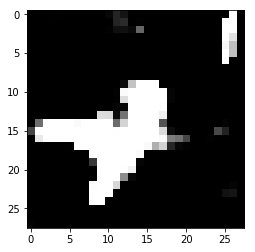

In [0]:
plt.imshow(test_output[90,:,:,0], cmap = 'gray')

In [0]:
x1.shape

(64, 28, 28)

In [0]:
5%300

5